<a href="https://colab.research.google.com/github/knpvlt/Personal/blob/main/SCM_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## **Задача 1**

In [26]:
data = pd.read_csv('/content/Книга1.csv', sep = ';')

In [27]:
data.head()

,week,Volume
0,04.01.2021,1 560 505
1,11.01.2021,1 746 612
2,18.01.2021,1 779 640
3,25.01.2021,1 847 611
4,01.02.2021,1 645 596


После загрузки данных очевидно, что их необходимо предобработать:

*   столбец week необходимо преобразовать в формат дат, чтобы облегчить группировку и агрегацию данных по неделям
*   столбец Volume удалить пробелы и преобразовать значения в целые числа



In [28]:
data['Volume'] = data['Volume'].str.replace(" ", '').astype(int)
data['week'] = pd.to_datetime(data['week'], format='%d.%m.%Y')

data.head()

,week,Volume
0,2021-01-04,1560505
1,2021-01-11,1746612
2,2021-01-18,1779640
3,2021-01-25,1847611
4,2021-02-01,1645596


Далее начинается работа над расчетом средних коэффициентов. Используя группировку по номеру недели, рассчитывается средний объем для каждой недели. Затем вычисляются средние коэффициенты сезонности для каждой недели, путем деления фактического объема на средний объем. Это позволяет определить, насколько текущий объем отличается от среднего значения для соответствующей недели.

In [29]:
seasonal_factors = data.groupby(data['week'].dt.week)['Volume'].mean() / data.groupby(data['week'].dt.week)['Volume'].mean().mean()

Создается датафрейм, в котором будут содержаться недели для 2023 года.

In [17]:
dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31', freq='W-MON')
df_2023 = pd.DataFrame({'week': dates_2023})

В уже заготовленный датафрейм 2023 года присоединяем вычисленные коэффициенты сезонности.

In [18]:
df_2023['seasonal_factor'] = df_2023['week'].dt.week.map(seasonal_factors)


In [23]:
df_2023.head()

,week,seasonal_factor
0,2023-01-02,0.630039
1,2023-01-09,0.705178
2,2023-01-16,0.718513
3,2023-01-23,0.745955
4,2023-01-30,0.664394


Строим линейный график изменения коэффицента сезонности для 2023 года по неделям.

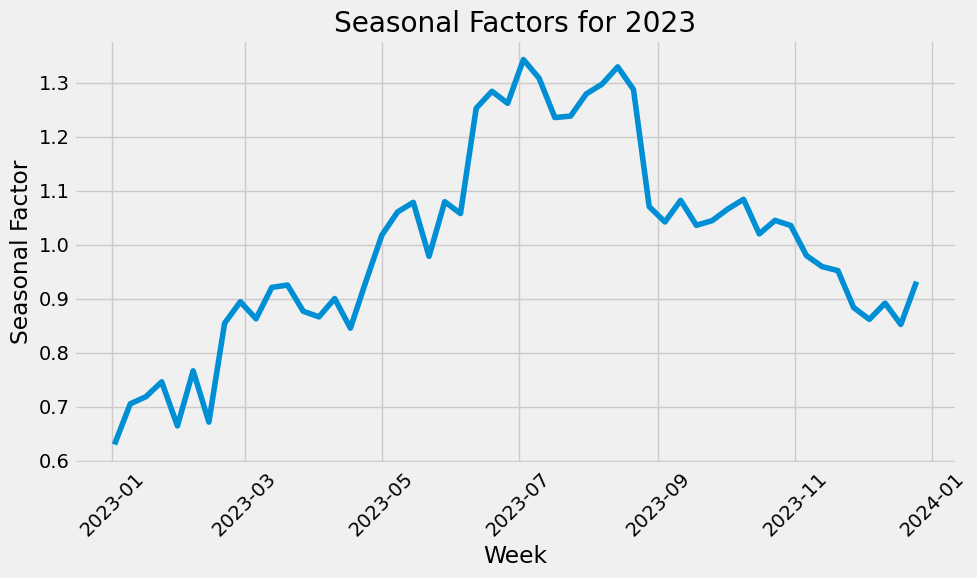

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_2023, x='week', y='seasonal_factor')
plt.title('Seasonal Factors for 2023')
plt.xlabel('Week')
plt.ylabel('Seasonal Factor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Задача 2**

In [222]:
data = pd.read_csv('/content/Книга2.csv', sep = ';')
data.head()

,year,month,week,GeneralizedSKUName,Volume
0,2020,1,06.01.2020,SKU_1,10 836
1,2020,1,06.01.2020,SKU_2,13 302
2,2020,1,13.01.2020,SKU_1,9 436
3,2020,1,13.01.2020,SKU_2,12 359
4,2020,1,20.01.2020,SKU_1,10 419


После загрузки данных очевидно, что их необходимо предобработать:

*   столбец week необходимо преобразовать в формат дат, чтобы облегчить группировку и агрегацию данных по неделям
*   столбец Volume удалить пробелы и преобразовать значения в целые числа



In [159]:
data['week'] = pd.to_datetime(data['week'], format='%d.%m.%Y')
data['Volume'] = data[' Volume'].str.replace(' ', '').astype(int)
data.drop([' Volume'], axis = 1, inplace = True)

In [160]:
data.head()

,year,month,week,GeneralizedSKUName,Volume
0,2020,1,2020-01-06,SKU_1,10836
1,2020,1,2020-01-06,SKU_2,13302
2,2020,1,2020-01-13,SKU_1,9436
3,2020,1,2020-01-13,SKU_2,12359
4,2020,1,2020-01-20,SKU_1,10419


Создаем список дат для прогнозирования продаж на 13 недель вперед.

In [161]:
forecast_weeks = pd.date_range(start=data['week'].max(), periods=14, freq='W-MON')[1:]


Создаем дефолтный датафрейм для внесения данных прогноза с соотвествующими недельными индексами.

In [162]:
forecast_df = pd.DataFrame(index = forecast_weeks, columns = ['SKU_1', 'SKU_2', 'SKU_3'])

Применяя модель экспотенциального сглаживания прогнозируем будущие продажи для каждого уникального SKU на основе исторических данных.

In [163]:
for sku in data['GeneralizedSKUName'].unique():
   temp_data = data[(data['GeneralizedSKUName'] == sku)].copy()
   temp_data.set_index('week', inplace=True)

   forecast = sm.tsa.ExponentialSmoothing(temp_data['Volume'], trend='add', seasonal='add', seasonal_periods=52).fit()
   forecast_value = forecast.forecast(steps=13)


   forecast_df[sku] = forecast_value.values

In [164]:
forecast_df.head()

,SKU_1,SKU_2,SKU_3
2022-12-19,17634.957563,33258.461186,17192.711676
2022-12-26,11053.203779,29804.795439,7879.783661
2023-01-02,16657.166511,41902.359151,16018.160976
2023-01-09,11817.071471,26554.993956,10255.223410
2023-01-16,11871.623447,33375.092719,11407.489156


Строим линейные графики прогнозных продаж на 13 недель вперед для каждого отдела.

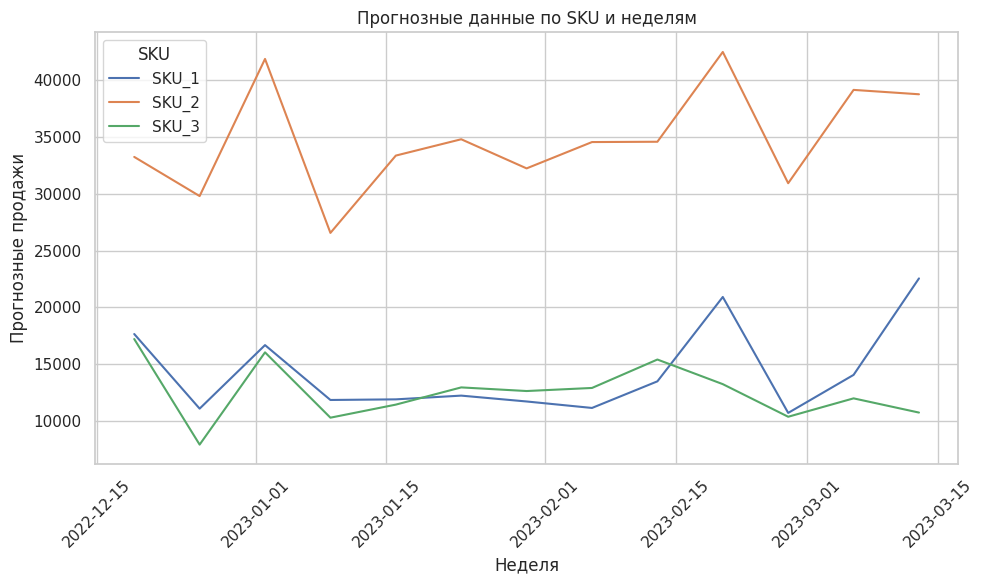

In [165]:
plt.figure(figsize=(10, 6))
for sku in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[sku], label=sku)

plt.title('Прогнозные данные по SKU и неделям')
plt.xlabel('Неделя')
plt.ylabel('Прогнозные продажи')
plt.legend(title='SKU')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Для более качественного прогноза по отделам продаж не хватает данных "SRegionsSBPName", поэтому приведенный прогноз учитывает лишь продажи разбитые по "GeneralizedSKUName".

## **Задача 3**

In [225]:
df_s_1 = pd.read_csv('/content/Книга3.1.csv', sep = ';')
df_s_2 = pd.read_csv('/content/Книга3.2.csv', sep = ';')
data = pd.read_csv('/content/Книга3.3.csv', sep = ';')


In [226]:
data.head()

,SRegionsSBPName,GeneralizedSKUCode,01.01.2020,01.02.2020,01.03.2020,01.01.2021,01.02.2021,01.03.2021
0,Барнаул,91993,31 409,27 056,26 718,33 851,35 763,38 320
1,Барнаул,63941,70 565,60 786,60 028,76 053,80 349,86 093
2,Барнаул,69521,96 544,83 164,82 126,104 052,109 929,117 787
3,Барнаул,72125,23 041,19 847,19 600,24 833,26 235,28 111
4,Барнаул,67054,38 775,33 401,32 985,41 791,44 151,47 307


После загрузки данных очевидно, что их необходимо предобработать:
*   в столбцах дат удалить пробелы и преобразовать значения в целые числа, которые будут характеризовать уровень продаж на данное число



In [227]:
dt_col = data.columns[2:]
for col in dt_col:
  data[col] = data[col].str.replace(' ', '').astype(int)


In [228]:
data.head()

,SRegionsSBPName,GeneralizedSKUCode,01.01.2020,01.02.2020,01.03.2020,01.01.2021,01.02.2021,01.03.2021
0,Барнаул,91993,31409,27056,26718,33851,35763,38320
1,Барнаул,63941,70565,60786,60028,76053,80349,86093
2,Барнаул,69521,96544,83164,82126,104052,109929,117787
3,Барнаул,72125,23041,19847,19600,24833,26235,28111
4,Барнаул,67054,38775,33401,32985,41791,44151,47307


Группируем таблицы по "GeneralizedSKUCode" и "SRegionsSBPName".

In [229]:
data_merged = data.merge(df_s_1, on='GeneralizedSKUCode', how='left')

In [230]:
data_final = data_merged.merge(df_s_2, on='SRegionsSBPName', how='left')


Сводим таблицу при этом подбивая итог помесячных продаж.

In [231]:
pivot_table = pd.pivot_table(data_final, values=['01.01.2020', '01.02.2020', '01.03.2020',
                                                 '01.01.2021', '01.02.2021', '01.03.2021'],
                             index=['Division', 'GeneralizedSKUName'],
                             aggfunc='sum')

In [232]:
pivot_table.head()

01.01.2020  01.01.2021  01.02.2020  \
Division              GeneralizedSKUName                                       
Дивизион Москва-Центр SKU_1                  1021400      977616      850849   
                      SKU_10                  843634     1022043      781504   
                      SKU_11                 1914218     2110288     1760285   
                      SKU_12                 1733722     1633005     1482959   
                      SKU_13                 2502212     2494545     2292022   

                                          01.02.2021  01.03.2020  01.03.2021  
Division              GeneralizedSKUName                                      
Дивизион Москва-Центр SKU_1                  1188140      872203     1347739  
                      SKU_10                 1103898     1009345     1218337  
                      SKU_11                 2401144     1983646     2590198  
                      SKU_12                 1788584     2171494     1859120  
                      SKU_13                 2707961     2511983     2836528

Создаем 6 столбцов, 3 из которых прирост продаж за каждый год, относительно месяца, а другие 3 - прирост в процентном соотношении.

In [233]:
pivot_table['Absolute_Growth_01.01'] = pivot_table['01.01.2021'] - pivot_table['01.01.2020']
pivot_table['Absolute_Growth_01.02'] = pivot_table['01.02.2021'] - pivot_table['01.02.2020']
pivot_table['Absolute_Growth_01.03'] = pivot_table['01.03.2021'] - pivot_table['01.03.2020']

# Добавление столбцов приростов в процентном выражении
pivot_table['Percentage_Growth_01.01'] = (pivot_table['01.01.2021'] - pivot_table['01.01.2020']) / pivot_table['01.01.2020'] * 100
pivot_table['Percentage_Growth_01.02'] = (pivot_table['01.02.2021'] - pivot_table['01.02.2020']) / pivot_table['01.02.2020'] * 100
pivot_table['Percentage_Growth_01.03'] = (pivot_table['01.03.2021'] - pivot_table['01.03.2020']) / pivot_table['01.03.2020'] * 100

# Вывод результата
pivot_table.head()

01.01.2020  01.01.2021  01.02.2020  \
Division              GeneralizedSKUName                                       
Дивизион Москва-Центр SKU_1                  1021400      977616      850849   
                      SKU_10                  843634     1022043      781504   
                      SKU_11                 1914218     2110288     1760285   
                      SKU_12                 1733722     1633005     1482959   
                      SKU_13                 2502212     2494545     2292022   

                                          01.02.2021  01.03.2020  01.03.2021  \
Division              GeneralizedSKUName                                       
Дивизион Москва-Центр SKU_1                  1188140      872203     1347739   
                      SKU_10                 1103898     1009345     1218337   
                      SKU_11                 2401144     1983646     2590198   
                      SKU_12                 1788584     2171494     1859120   
                      SKU_13                 2707961     2511983     2836528   

                                          Absolute_Growth_01.01  \
Division              GeneralizedSKUName                          
Дивизион Москва-Центр SKU_1                              -43784   
                      SKU_10                             178409   
                      SKU_11                             196070   
                      SKU_12                            -100717   
                      SKU_13                              -7667   

                                          Absolute_Growth_01.02  \
Division              GeneralizedSKUName                          
Дивизион Москва-Центр SKU_1                              337291   
                      SKU_10                             322394   
                      SKU_11                             640859   
                      SKU_12                             305625   
                      SKU_13                             415939   

                                          Absolute_Growth_01.03  \
Division              GeneralizedSKUName                          
Дивизион Москва-Центр SKU_1                              475536   
                      SKU_10                             208992   
                      SKU_11                             606552   
                      SKU_12                            -312374   
                      SKU_13                             324545   

                                          Percentage_Growth_01.01  \
Division              GeneralizedSKUName                            
Дивизион Москва-Центр SKU_1                             -4.286665   
                      SKU_10                            21.147678   
                      SKU_11                            10.242825   
                      SKU_12                            -5.809294   
                      SKU_13                            -0.306409   

                                          Percentage_Growth_01.02  \
Division              GeneralizedSKUName                            
Дивизион Москва-Центр SKU_1                             39.641699   
                      SKU_10                            41.253020   
                      SKU_11                            36.406548   
                      SKU_12                            20.609133   
                      SKU_13                            18.147252   

                                          Percentage_Growth_01.03  
Division              GeneralizedSKUName                           
Дивизион Москва-Центр SKU_1                             54.521253  
                      SKU_10                            20.705705  
                      SKU_11                            30.577633  
                      SKU_12                           -14.385211  
                      SKU_13                            12.919872

## **Задача 4**

In [234]:
data = pd.read_csv('/content/Книга4.csv', sep = ';')

In [235]:
data.head()

,SRegionsSBPName,GeneralizedSKUCode,02.01.2023,09.01.2023,16.01.2023,23.01.2023,30.01.2023,06.02.2023,13.02.2023,20.02.2023,...,20.05.2024,27.05.2024,03.06.2024,10.06.2024,17.06.2024,24.06.2024,01.07.2024,08.07.2024,15.07.2024,22.07.2024
0,Барнаул,79934,2 301,2 239,2 115,2 160,2 131,2 166,2 395,2 667,...,2 871,2 841,3 083,3 431,3 646,3 194,3 277,3 758,3 719,3 219
1,Барнаул,94957,5 170,5 030,4 751,4 852,4 787,4 867,5 381,5 992,...,6 450,6 383,6 927,7 708,8 192,7 175,7 362,8 443,8 356,7 232
2,Барнаул,57466,7 073,6 882,6 501,6 639,6 549,6 659,7 362,8 198,...,8 824,8 733,9 477,10 546,11 207,9 816,10 072,11 551,11 432,9 895
3,Барнаул,36609,1 688,1 643,1 551,1 584,1 563,1 589,1 757,1 957,...,2 106,2 084,2 262,2 517,2 675,2 343,2 404,2 757,2 728,2 361
4,Барнаул,49463,2 841,2 764,2 611,2 666,2 630,2 674,2 957,3 293,...,3 544,3 507,3 806,4 236,4 501,3 943,4 045,4 639,4 591,3 974


Преобразовываем данные из "плоского" вида в "длинный".

In [236]:
melted_data = pd.melt(data, id_vars=['SRegionsSBPName', 'GeneralizedSKUCode'], var_name='Date', value_name='Volume')


Предобрабатываем данные:

*   столбец Date необходимо преобразовать в формат дат
*   в столбце Volume удаляем пробелы и преобразовываем в целые числа



In [237]:
melted_data['Date'] = pd.to_datetime(melted_data['Date'])
melted_data['Volume'] = melted_data['Volume'].str.replace(' ', '').astype(int)
melted_data.head()

,SRegionsSBPName,GeneralizedSKUCode,Date,Volume
0,Барнаул,79934,2023-02-01,2301
1,Барнаул,94957,2023-02-01,5170
2,Барнаул,57466,2023-02-01,7073
3,Барнаул,36609,2023-02-01,1688
4,Барнаул,49463,2023-02-01,2841


Сводим таблицу по "GeneralizedSKUCode", месяцу и объему в 2023 и в 2024 годах.

In [238]:
pivot_table = melted_data.pivot_table(index=['GeneralizedSKUCode', melted_data['Date'].dt.month],
                                      columns=melted_data['Date'].dt.year,
                                      values='Volume', aggfunc='sum')


In [239]:
pivot_table.head()

Date                       2023    2024
GeneralizedSKUCode Date                
10053              1     5026.0  8234.0
                   2     6631.0  2747.0
                   3     7252.0  4510.0
                   4     5389.0  5776.0
                   5     6497.0  5980.0